In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from scipy.optimize import minimize
import numpy as np
from epimodels.discrete.models import SEQIAHR
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
from matplotlib.pyplot import figure
figure(num=None, figsize=(18, 10), dpi=80)

<Figure size 1440x800 with 0 Axes>

<Figure size 1440x800 with 0 Axes>

# SEIAHR model

In [32]:
model  = SEQIAHR()

In [33]:
pars = {
    'chi': .5,#0.05188433291603778,
    'phi': 0.012413633926076584,
    'beta': 0.2,
    'rho': 0.3,
    'delta': 0.1,
    'gamma': 0.04,
    'alpha': 0.3413355572047603,
    'mu': 0.02359234606623134,
    'p': 0.7693029079871165,
    'q': 50,#6.635760900566002,
    'r': 55#28.637912453634094
}
model([.99, 0, 1e-6, 0, 0, 0, 0, 0], [0, 300], 1, pars)

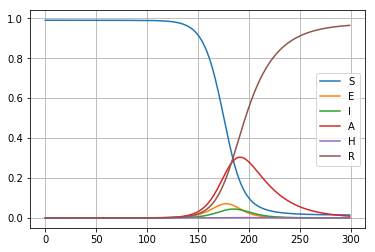

In [34]:
model.plot_traces(vars=['S','E','Q','I','A','H','R'])
#plt.savefig('containment.png', dpi=400)

plt.title('');

## Load data

In [ ]:
cases = pd.read_csv('covid19_18_06.csv')
# Pegando os casos do Brasil.io
# cases = pd.read_csv('https://brasil.io/dataset/covid19/caso_full/?format=csv')
cases.date = pd.to_datetime(cases.date)

In [ ]:
df_states = cases[cases.place_type!='state'].groupby(['date','state']).sum()
df_states.reset_index(inplace=True)
df_states.set_index('date', inplace=True)

In [ ]:
# df_states.set_index('date', inplace=True)
fig,ax = plt.subplots(1,1,figsize=(15,8))

for uf in ['SP','RJ','MG','CE','RS', 'PE', 'AM', 'BA']:
    df_states[df_states.state==uf].last_available_confirmed.plot(ax=ax,style='-o', label=uf, grid=True)

ax.legend()
#plt.savefig('Casos_confirmados_estados.png',dpi=200)

#### Simulação SP

In [ ]:
df_SP = df_states[df_states.state=='SP'][['last_available_confirmed','new_confirmed','last_available_deaths', 'new_deaths']]
df_SP.columns = ['Confirmados','Casos_novos','Mortes','Mortes_novas']

In [ ]:
popSP = 12.28e6
subnot=0.8

def plot_fit(data, pop, model, offset):
    f,(ax1,ax2) = plt.subplots(2,1,figsize=(15,10))
    data.plot(ax=ax1,style=':*', grid=True)
    ax1.plot(model.traces['time'][offset:]-offset,model.traces['C'][offset:]*pop*subnot, label='casos' );
    ax1.plot(model.traces['time'][offset:]-offset,model.traces['D'][offset:]*pop, label='Mortes' );
    ax1.legend();
    ax2.plot(model.traces['time'][offset:]-offset,model.traces['I'][offset:]*pop, label='Infected')
    ax2.plot(model.traces['time'][offset:]-offset,model.traces['A'][offset:]*pop, label='Asymptomatic')
#     ax2.plot(model.traces['time'][offset:]-offset,model.traces['S'][offset:]*pop, label='Susceptible')
    ax2.grid()
    ax2.legend()
plot_fit(df_SP[['Confirmados', 'Mortes']], popSP, model, 30);

In [ ]:
pardict = {
 'chi': .5,#0.05188433291603778,
    'phi': 0.012413633926076584,
    'beta': 0.2,
    'rho': 0.6,
    'delta': 0.1,
    'gamma': 0.04,
    'alpha': 0.3413355572047603,
    'mu': 0.02359234606623134,
    'p': 0.7693029079871165,
    'q': 50,#6.635760900566002,
    'r': 55, #28.637912453634094
    'offset': 25
}

In [ ]:
parn = list(pardict.keys())
parv = list(pardict.values())

In [ ]:
data = df_SP[['Confirmados', 'Mortes']]
ld = len(data)
def loss(pars):
    pars = list(pars)
    offs = int(np.round(pars.pop()))
#     print(dict(zip(parn[:-1],pars)))
    model([.99, 0, 1e-6, 0, 0, 0, 0, 0], [0, ld+offs], 1, dict(zip(parn[:-1],pars)))
    C=model.traces['C'][offs:offs+ld]*popSP*subnot
    D=model.traces['D'][offs:offs+ld]*popSP
    loss  = sum((data.Confirmados-C)**2) +sum((data.Mortes-D)**2)/2*len(data)
    return loss

In [ ]:
res = minimize(
    loss,
    parv,
    #          method='COBYLA',
    method='L-BFGS-B',
    #                method='TNC',
    bounds=[(0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 2.0), (0.0, 1.0),
            (0.0, 2.0), (0.0, 1.0), (0.0, 1.0),(.35, 1), (0, 30), (0, 90),
                                                   (0, 40)],
    options={'maxiter': 250})
print("Sucess: ", res['success'])

In [ ]:
def R0(prs):
    chi,phi,beta,rho, delta,gamma,alpha,mu,p,q,r,offset=prs
    B = beta*chi-beta
    return -B*(p*phi+gamma+(delta-gamma)*p)/(gamma*(delta+phi))
print(dict(zip(parn,res['x'])))
plot_fit(data,popSP, model, int(res['x'][-1]))
print("R0=", R0(res['x']))

## Optimization with PuLP

In [ ]:
import pulp as pl

In [ ]:
opt_prob = pl.LpProblem("Parameter_finding", pl.LpMinimize)
chi = pl.LpVariable('chi', lowBound=0, cat='Continuous')
phi = pl.LpVariable('phi', lowBound=0, upBound=1, cat='Continuous')
beta = pl.LpVariable('beta', lowBound=0, cat='Continuous')
rho = pl.LpVariable('rho', lowBound=0, cat='Continuous')
delta = pl.LpVariable('delta', lowBound=0, cat='Continuous')
alpha = pl.LpVariable('alpha', lowBound=0, cat='Continuous')
mu = pl.LpVariable('mu', lowBound=0, cat='Continuous')
p = pl.LpVariable('p', lowBound=0, upBound=1, cat='Continuous')
q = pl.LpVariable('q', lowBound=0, cat='Continuous')
r = pl.LpVariable('r', lowBound=0, cat='Continuous')
offset = pl.LpVariable('offset', lowBound=0, upBound=60, cat='Integer')

In [ ]:
#adding the loss function
opt_prob += loss([chi,phi,beta,rho,delta,alpha,mu,p,q,r,offset])

## Tensorflow edward2 estimation

In [ ]:
from tensorflow_probability import edward2 as ed

In [ ]:
n = ed.Normal(0,1)
print(n**2)

In [ ]:
pars

In [ ]:
mod  = SEQIAHR()
def ed_model():
    mod  = SEQIAHR()
    pars ={
    'chi': ed.Uniform(),# 0.05188433291603778,
    'phi': ed.Uniform(), #0.012413633926076584,
    'beta': ed.Uniform(),#0.47272459855759813,
    'rho': ed.Uniform(),#0.2190519831830368,
    'delta': ed.Uniform(), #0.04168480042146949,
    'gamma': ed.Uniform(),
    'alpha': ed.Uniform(),#0.3413355572047603,
    'mu': ed.Uniform(), #0.02359234606623134,
    'p': ed.Uniform(), #0.7693029079871165,
    'q': ed.Uniform(0,30), #6.635760900566002,
    'r': ed.Uniform(0,60), #28.637912453634094
            }
    return mod([.99, 0, 1e-6, 0, 0, 0, 0, 0], [0, 300], 1, pars)
    

In [ ]:
ed_model()

In [ ]:
#Retorna None

In [ ]:
plot_fit(data,popSP,ed_model(), 30)

In [ ]:
data

## PyMC4 Estimation

In [ ]:
import pymc4 as pm
import tensorflow as tf
import arviz as az

In [ ]:
mod  = SEQIAHR()

@tf.autograph.experimental.do_not_convert
def get_sim(pars):
    for k, v in pars.items():
#         print(k, type(v))
        try:
#             print(v.numpy())
            pars[k] = v.numpy()
        except:
#             print(dir(v))
#             sess = tf1.Session()
#             print(v.eval(session=sess))
            pars[k] = 0#v.eval(session=sess)
#         pars = {k:v.numpy() for k,v in pars.items()}
    popSP = 12.28e6
    offset = 30
    mod([.99, 0, 1e-6, 0, 0, 0, 0, 0], [0, 300], 1, pars)
    C=mod.traces['C'][offset:offset+ld]*popSP
    D=mod.traces['D'][offset:offset+ld]*popSP
    return C.astype('float32'),D.astype('float32')
    
    
@pm.model
def SEIAHR_model():
    chi = yield pm.Uniform('chi', 0,1)# 0.05188433291603778,
    phi = yield pm.Uniform('phi', 0,1) #0.012413633926076584,
    beta = yield pm.Uniform('beta', 0,1)#0.47272459855759813,
    rho = yield pm.Uniform('rho', 0,1)#0.2190519831830368,
    delta = yield pm.Uniform('delta', 0,1) #0.04168480042146949,
    gamma = yield pm.Uniform('gamma', 0,1) #,
    alpha = yield pm.Uniform('alpha', 0,1)#0.3413355572047603,
    mu = yield pm.Uniform('mu', 0,1) #0.02359234606623134,
    p = yield pm.Uniform('p', 0,1) #0.7693029079871165,
    q = yield pm.Uniform('q',0,30) #6.635760900566002,
    r = yield pm.Uniform('r',0,60) #28.637912453634094
    
    pars = dict(zip(parn,[chi,phi,beta,rho,delta,gamma,alpha,mu,p,q,r]))
    res = get_sim(pars)
    casos, mortes = res
#     par_pois = yield pm.Exponential('lamb',1/100)
    incidencia = yield pm.Poisson('incidência', rate=casos, shape=(1,len(casos)))
    mortalidade = yield pm.Poisson('mortalidade', rate=mortes, shape=(1,len(mortes)))
#     Verossimilhanças
    L_casos = pm.Poisson('Lik_casos', rate=incidencia, observed=data.Confirmados)
    L_mortes = pm.Poisson('Lik_mortes', rate=mortalidade, observed=data.Mortes)

In [ ]:
%time data = pm.sample(SEIAHR_model(), num_chains=16)

In [ ]:
az.plot_trace(data);